In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from window import WindowGenerator

# Inspect and cleanup

## Read datasets

In [8]:
# inlets
inlets = pd.read_csv("datasets/all_inlets.csv")
inlets = inlets.drop(["Case_id", "Time"], axis=1)
inlets = inlets.add_prefix("inlet_")

# outlets
outlets = pd.read_csv("datasets/all_outlets.csv")
outlets = outlets.drop(["Case_id", "Time", "fan_speed"], axis=1)
outlets = outlets.add_prefix("outlet_")

## Visualize data

### Inlet

In [9]:
print(len(inlets))
inlets.head()

1752


,inlet_fan_speed,inlet_1,inlet_2,inlet_3,inlet_4,inlet_5,inlet_6,inlet_7,inlet_8,inlet_9,...,inlet_126,inlet_127,inlet_128,inlet_129,inlet_130,inlet_131,inlet_132,inlet_133,inlet_134,inlet_135
0,50.0,25.92,25.003333,24.086667,23.17,20.38,18.145,15.91,15.155,14.40,...,21.36,26.54,26.576667,26.613333,26.65,26.03,24.605,23.18,26.090,29.00
1,50.0,26.08,25.150000,24.220000,23.29,20.23,18.650,17.07,15.745,14.42,...,21.56,26.07,26.900000,27.730000,28.56,27.20,25.775,24.35,26.745,29.14
2,50.0,25.85,25.053333,24.256667,23.46,19.84,18.070,16.30,15.370,14.44,...,20.99,26.33,26.636667,26.943333,27.25,26.01,24.855,23.70,26.355,29.01
3,50.0,25.78,24.846667,23.913333,22.98,18.99,17.465,15.94,15.220,14.50,...,21.04,25.99,26.213333,26.436667,26.66,26.17,24.775,23.38,26.165,28.95
4,50.0,25.80,24.776667,23.753333,22.73,20.04,18.170,16.30,15.500,14.70,...,21.29,26.74,26.960000,27.180000,27.40,25.97,24.775,23.58,26.290,29.00


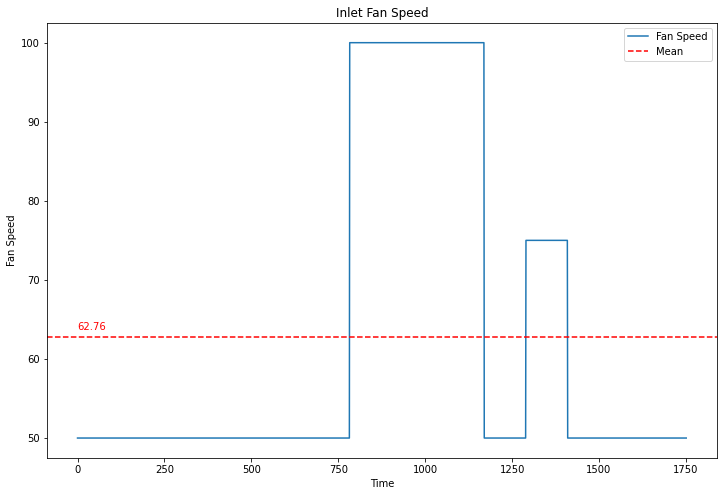

In [42]:
fig, ax = plt.subplots()

inlets['inlet_fan_speed'].plot(title="Inlet Fan Speed", figsize=(12,8), xlabel="Time", ylabel="Fan Speed", label="Fan Speed")

mean = inlets['inlet_fan_speed'].mean()
plt.axhline(mean, color='r', linestyle='dashed', label='Mean')
ax.text(0, mean+1, "{:.2f}".format(mean), color='r')

plt.legend()

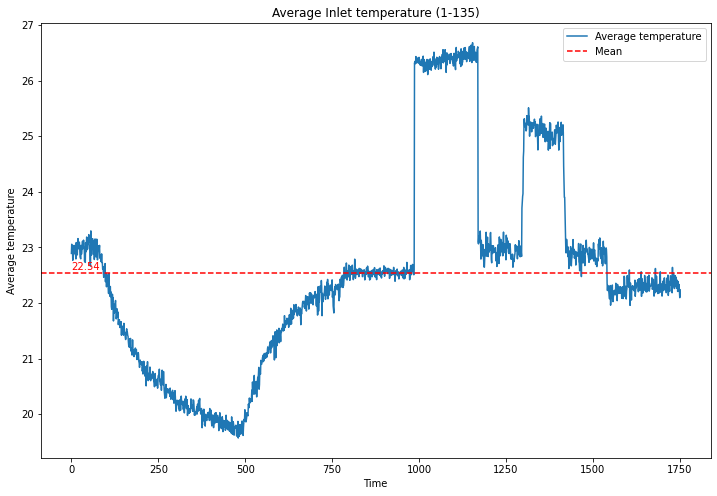

In [43]:
fig, ax = plt.subplots()

inlets.drop("inlet_fan_speed", axis=1).mean(axis=1).plot(title="Average Inlet temperature (1-135)", figsize=(12,8), xlabel="Time", ylabel="Average temperature", label="Average temperature")

mean = inlets.drop("inlet_fan_speed", axis=1).mean().mean()
plt.axhline(mean, color='r', linestyle='dashed', label='Mean')
ax.text(0, mean+0.05, "{:.2f}".format(mean), color='r')

plt.legend()

### Outlet

In [10]:
print(len(outlets))
outlets.head()

1752


,outlet_1,outlet_2,outlet_3,outlet_4,outlet_5,outlet_6,outlet_7,outlet_8,outlet_9,outlet_10,...,outlet_126,outlet_127,outlet_128,outlet_129,outlet_130,outlet_131,outlet_132,outlet_133,outlet_134,outlet_135
0,25.92,25.003333,24.086667,23.17,20.38,18.145,15.91,15.155,14.40,25.85,...,21.36,26.54,26.576667,26.613333,26.65,26.03,24.605,23.18,26.090,29.00
1,26.08,25.150000,24.220000,23.29,20.23,18.650,17.07,15.745,14.42,25.49,...,21.56,26.07,26.900000,27.730000,28.56,27.20,25.775,24.35,26.745,29.14
2,25.85,25.053333,24.256667,23.46,19.84,18.070,16.30,15.370,14.44,25.27,...,20.99,26.33,26.636667,26.943333,27.25,26.01,24.855,23.70,26.355,29.01
3,25.78,24.846667,23.913333,22.98,18.99,17.465,15.94,15.220,14.50,25.13,...,21.04,25.99,26.213333,26.436667,26.66,26.17,24.775,23.38,26.165,28.95
4,25.80,24.776667,23.753333,22.73,20.04,18.170,16.30,15.500,14.70,25.47,...,21.29,26.74,26.960000,27.180000,27.40,25.97,24.775,23.58,26.290,29.00


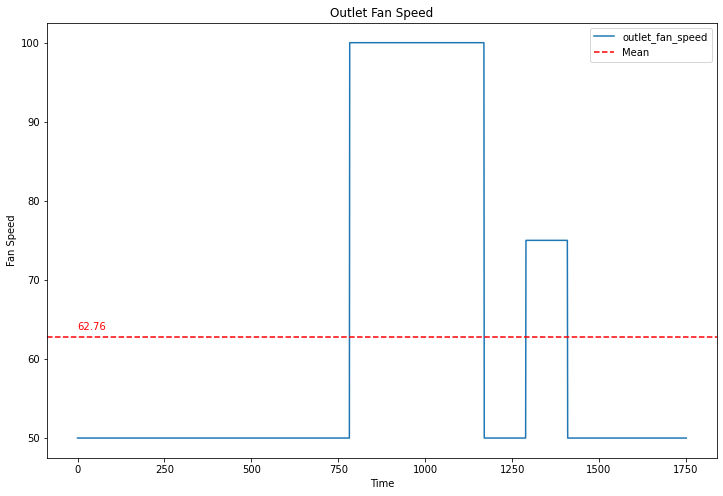

In [45]:
fig, ax = plt.subplots()

outlets['outlet_fan_speed'].plot(title="Outlet Fan Speed", figsize=(12,8), xlabel="Time", ylabel="Fan Speed")

mean = outlets['outlet_fan_speed'].mean()
plt.axhline(mean, color='r', linestyle='dashed', label='Mean')
ax.text(0, mean+1, "{:.2f}".format(mean), color='r')

plt.legend()

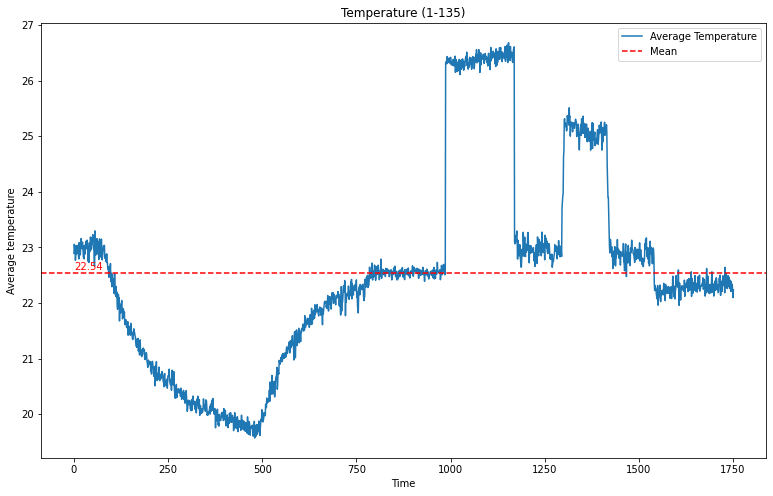

In [46]:
fig, ax = plt.subplots()

outlets.drop("outlet_fan_speed", axis=1).mean(axis=1).plot(
    title="Temperature (1-135)",
    figsize=(13,8),
    xlabel="Time",
    ylabel="Average temperature",
    label="Average Temperature"
)

mean = outlets.drop("outlet_fan_speed", axis=1).mean().mean()

plt.axhline(mean, color='r', linestyle='dashed', label='Mean')
ax.text(0, mean+0.05, "{:.2f}".format(mean),color='r')

plt.legend()

# Preprocessing

We will use the outlet temperatures as the label columns, because it's what we would like to predict.

In [11]:
df = pd.concat([inlets, outlets], axis=1)
column_indices = {name: i for i, name in enumerate(df.columns)}

In [13]:
label_columns = outlets.columns.values
label_columns

array(['outlet_1', 'outlet_2', 'outlet_3', 'outlet_4', 'outlet_5',
       'outlet_6', 'outlet_7', 'outlet_8', 'outlet_9', 'outlet_10',
       'outlet_11', 'outlet_12', 'outlet_13', 'outlet_14', 'outlet_15',
       'outlet_16', 'outlet_17', 'outlet_18', 'outlet_19', 'outlet_20',
       'outlet_21', 'outlet_22', 'outlet_23', 'outlet_24', 'outlet_25',
       'outlet_26', 'outlet_27', 'outlet_28', 'outlet_29', 'outlet_30',
       'outlet_31', 'outlet_32', 'outlet_33', 'outlet_34', 'outlet_35',
       'outlet_36', 'outlet_37', 'outlet_38', 'outlet_39', 'outlet_40',
       'outlet_41', 'outlet_42', 'outlet_43', 'outlet_44', 'outlet_45',
       'outlet_46', 'outlet_47', 'outlet_48', 'outlet_49', 'outlet_50',
       'outlet_51', 'outlet_52', 'outlet_53', 'outlet_54', 'outlet_55',
       'outlet_56', 'outlet_57', 'outlet_58', 'outlet_59', 'outlet_60',
       'outlet_61', 'outlet_62', 'outlet_63', 'outlet_64', 'outlet_65',
       'outlet_66', 'outlet_67', 'outlet_68', 'outlet_69', 'outlet_70',
 

## Split the data

In [14]:
n = len(df)

train_df = df[0:int(n*0.7)]         # 70% for training
val_df = df[int(n*0.7):int(n*0.9)]  # 20% for validation
test_df = df[int(n*0.9):]           # 10% for testing

num_features = df.shape[1]
print(num_features)

271


## Data normalization

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Window

In [18]:
OUT_STEPS = 120 # 10 minutes into the future (given each time step is 5s)

In [20]:
window = WindowGenerator(input_width=10, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df,
                         val_df=val_df, test_df=test_df, label_columns=label_columns)

window


Total window size: 145
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144]
Label column name(s): ['outlet_1' 'outlet_2' 'outlet_3' 'outlet_4' 'outlet_5' 'outlet_6'
 'outlet_7' 'outlet_8' 'outlet_9' 'outlet_10' 'outlet_11' 'outlet_12'
 'outlet_13' 'outlet_14' 'outlet_15' 'outlet_16' 'outlet_17' 'outlet_18'
 'outlet_19' 'outlet_20' 'outlet_21' 'outlet_22' 'outlet_23' 'outlet_24'
 'outlet_25' 'outlet_26' 'outlet_27' 'outlet_28' 'outlet_29' 'outlet_30

# Model creation

In [46]:
input_size = 1
output_size = 135
hidden_layer_units = 10

In [47]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(input_size,)),
    tf.keras.layers.Dense(hidden_layer_units, activation='relu'), # hidden layer
    tf.keras.layers.Dense(output_size) # output layer
])

In [48]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

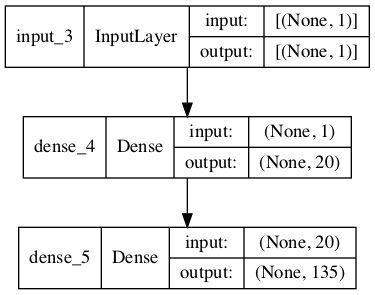

In [49]:
# model.summary()
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [50]:
model.fit(
    X_train, y_train,
    epochs=124,
    validation_data=(X_test, y_test)
)

Epoch 1/124
50/50 [==============================] - 1s 6ms/step - loss: 525.5995 - accuracy: 0.0000e+00 - val_loss: 525.8961 - val_accuracy: 0.0000e+00
Epoch 2/124
50/50 [==============================] - 0s 2ms/step - loss: 516.7891 - accuracy: 0.0019 - val_loss: 513.4100 - val_accuracy: 0.0000e+00
Epoch 3/124
50/50 [==============================] - 0s 2ms/step - loss: 499.9601 - accuracy: 0.0019 - val_loss: 492.3601 - val_accuracy: 0.0000e+00
Epoch 4/124
50/50 [==============================] - 0s 2ms/step - loss: 475.0583 - accuracy: 0.0019 - val_loss: 463.7353 - val_accuracy: 0.0000e+00
Epoch 5/124
50/50 [==============================] - 0s 2ms/step - loss: 443.0143 - accuracy: 0.0019 - val_loss: 428.6721 - val_accuracy: 0.0000e+00
Epoch 6/124
50/50 [==============================] - 0s 2ms/step - loss: 405.4853 - accuracy: 0.0019 - val_loss: 389.3012 - val_accuracy: 0.0000e+00
Epoch 7/124
50/50 [==============================] - 0s 2ms/step - loss: 364.1589 - accuracy: 0.0019 -

In [51]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:title={'center':'Model loss'}, xlabel='Epoch', ylabel='Loss'>

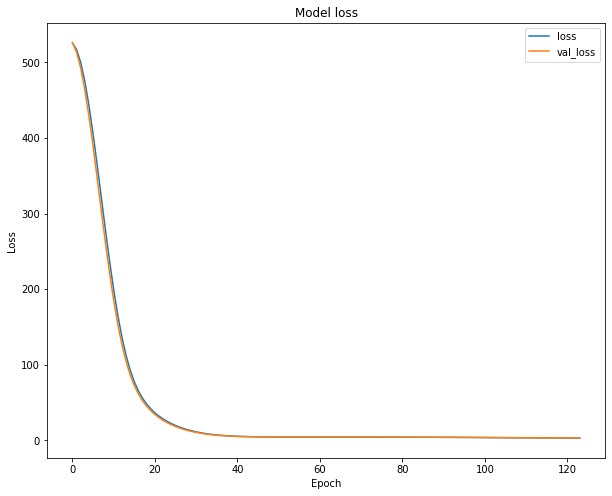

In [52]:
losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")

In [53]:
preds = model.predict(X_test)
print(preds.shape)

(176, 135)


In [54]:
from sklearn.metrics import mean_squared_error

In [55]:
math.sqrt(mean_squared_error(y_test, preds))

1.7816428589114273